<a href="https://colab.research.google.com/github/mohankrishna12/Pulse_BirdSoundRecognition/blob/main/birdclef2023_mel_torch_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Group Project of **DA623** at *IITG (2023 Jan-May Semester)*

Team Name : **Pulse**

Members:
Pallapu Mohan Krishna,Shania H,Avantika Sahu

In [ ]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
from torchvision import datasets, transforms, models 
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

# Set Train and Test

In [ ]:
paths=[]
labels=[]
for dirname, _, filenames in os.walk('/kaggle/input/birdclef2023-sound-j-0-to-mel'):
    for filename in filenames:
        if filename[-4:]=='.png' and 'results' not in filename:
            path=os.path.join(dirname, filename)
            paths+=[path]
            label=path.split('/')[-1].split('_')[0]
            labels+=[label]

In [ ]:
df=pd.DataFrame(columns=['path','label'])
df['path']=paths
df['label']=labels
display(df['label'].value_counts())

wlwwar     468
ratcis1    172
rindov     116
moccha1     36
cabgre1     34
walsta1     34
sltnig1     33
yetgre1     27
sobfly1     21
norfis1     20
rostur1     10
brrwhe3      8
pabspa1      7
equaka1      7
macshr1      6
crefra2      1
Name: label, dtype: int64

In [ ]:
df=df[df['label']!='crefra2']

In [ ]:
class_names=sorted(df['label'].unique().tolist())
N=list(range(len(class_names)))
print(len(class_names))
normal_mapping=dict(zip(class_names,N)) 
reverse_mapping=dict(zip(N,class_names))
df['labeli']=df['label'].map(normal_mapping)
print(normal_mapping)

15
{'brrwhe3': 0, 'cabgre1': 1, 'equaka1': 2, 'macshr1': 3, 'moccha1': 4, 'norfis1': 5, 'pabspa1': 6, 'ratcis1': 7, 'rindov': 8, 'rostur1': 9, 'sltnig1': 10, 'sobfly1': 11, 'walsta1': 12, 'wlwwar': 13, 'yetgre1': 14}


In [ ]:
train_transform=transforms.Compose([ 
    transforms.Resize(217),
    transforms.ToTensor()])

In [ ]:
# CAUTION!!! 
path0='/kaggle/input/birdclef2023-sound-j-0-to-mel/mel/brrwhe3_XC289781.png'
img = Image.open(path0)
print(type(img))
img1 = np.array(img)
print(type(img1),img1.shape)#(217, 217, 4)
img2=cv2.imread(path0)
print(type(img2),img2.shape)#(217, 217, 3)
#display(train_transform(img))##OK
#display(train_transform(img1))##impossible
#display(train_transform(img2))##impossible

<class 'PIL.PngImagePlugin.PngImageFile'>
<class 'numpy.ndarray'> (217, 217, 4)
<class 'numpy.ndarray'> (217, 217, 3)


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_path = self.df.iloc[index]['path']
        img = Image.open(img_path)        
        if self.transform:
            img = self.transform(img)
        label = self.df.iloc[index]['labeli']

        return img, label

In [ ]:
dataset = CustomDataset(df, transform=train_transform)

In [ ]:
#one by one
for images, labels in dataset:
    print(type(images))
    print(images.shape)#torch.Size([32, 4, 217, 217])
    break

<class 'torch.Tensor'>
torch.Size([4, 217, 217])


In [ ]:
dataset_size = len(dataset)
indices = list(range(dataset_size))

split_ratio = 0.8
split_index = int(dataset_size * split_ratio)
train_indices = indices[:split_index]
test_indices = indices[split_index:]

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = DataLoader(dataset, batch_size=32, sampler=train_sampler)
test_loader = DataLoader(dataset, batch_size=32, sampler=test_sampler)

# Images and Labels

In [ ]:
#batch by batch
for images, labels in train_loader:
    print(type(images))    
    print(images.shape)#torch.Size([32, 4, 217, 217])
    break
im=make_grid(images,nrow=8)

<class 'torch.Tensor'>
torch.Size([32, 4, 217, 217])


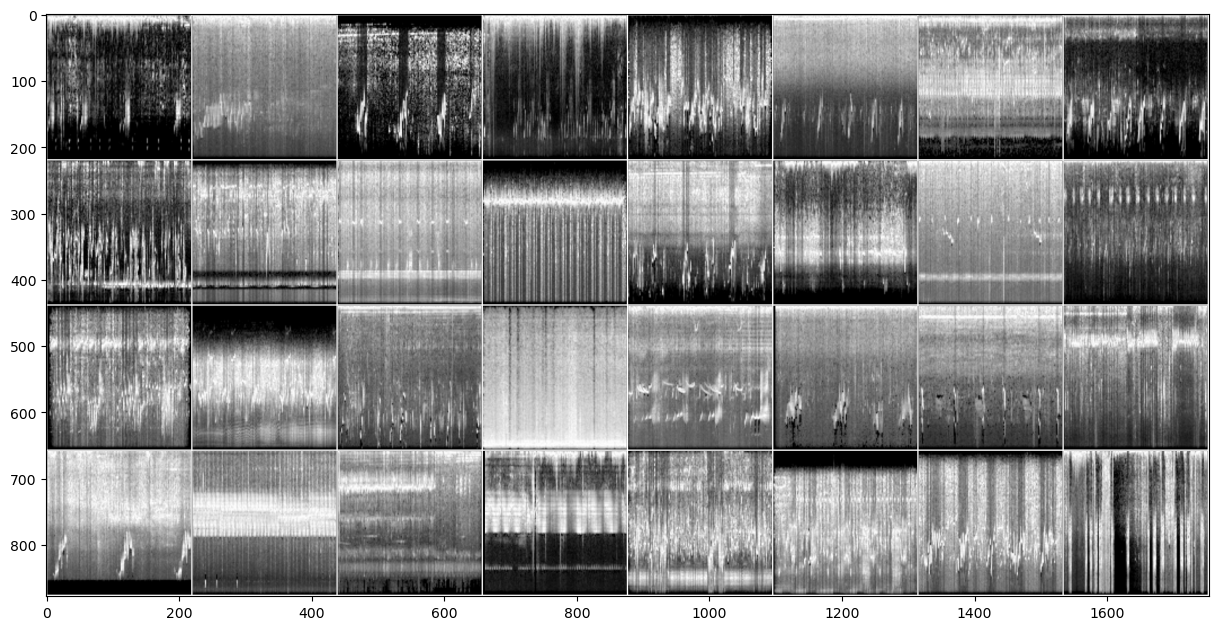

In [ ]:
plt.figure(figsize=(15,10))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))
plt.show()

# CNN Model

In [ ]:
class MyCNN(nn.Module):
    
    def __init__(self):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, 3, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64 * 108 * 108, 128)  # 217 / 2 = 108
        self.relu3 = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(128, 16)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

In [ ]:
model=MyCNN()
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.0001)

In [ ]:
model

MyCNN(
  (conv1): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=746496, out_features=128, bias=True)
  (relu3): ReLU(inplace=True)
  (fc2): Linear(in_features=128, out_features=16, bias=True)
)

# Fit

In [ ]:
import time
start_time=time.time()
train_losses=[]
test_losses=[]
train_correct=[]
test_correct=[]
epochs=30

for i in range(epochs):
    #print(i)
    trn_corr = 0
    tst_corr = 0
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b % 200 == 0:
            print(f"epoch: {i} loss: {loss.item()} batch: {b} accuracy: {trn_corr.item() * 100 / (10 * b):7.3f}%")
    loss = loss.detach().numpy()
    train_losses.append(loss)
    train_correct.append(trn_corr)

    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)
            loss = criterion(y_val, y_test)

            predicted = torch.max(y_val.data, 1)[1]
            batch_corr = (predicted == y_test).sum()
            tst_corr += batch_corr

        loss = loss.detach().numpy()
        test_losses.append(loss)
        test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds')



Duration: 4842 seconds


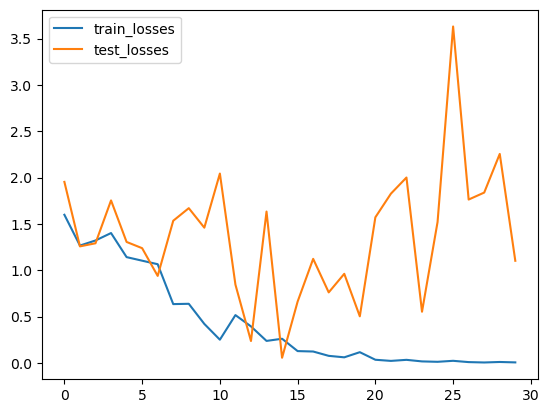

In [ ]:
plt.plot(train_losses,label="train_losses")
plt.plot(test_losses,label="test_losses")
plt.legend()
plt.show()

In [ ]:
# save model
torch.save(model.state_dict(), 'model.pt') 
#new_model = ConvolutionalNetwork()
#new_model.load_state_dict(torch.load('model.pt'))

# Predict

In [ ]:
device = torch.device("cpu")   #"cuda:0"
model.eval()

y_true=[]
y_pred=[]
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())
print(y_pred[0:5])

[13, 13, 13, 7, 8]


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred,target_names=class_names,digits=4))

              precision    recall  f1-score   support

     brrwhe3     0.3333    0.3333    0.3333         3
     cabgre1     0.8333    0.5556    0.6667         9
     equaka1     0.0000    0.0000    0.0000         2
     macshr1     1.0000    1.0000    1.0000         1
     moccha1     0.0000    0.0000    0.0000         9
     norfis1     0.0000    0.0000    0.0000         4
     pabspa1     0.0000    0.0000    0.0000         1
     ratcis1     0.4474    0.6071    0.5152        28
      rindov     0.8500    0.8947    0.8718        19
     rostur1     0.0000    0.0000    0.0000         2
     sltnig1     1.0000    1.0000    1.0000         3
     sobfly1     0.0000    0.0000    0.0000         4
     walsta1     0.5714    0.5000    0.5333         8
      wlwwar     0.8393    0.8952    0.8664       105
     yetgre1     0.1429    0.5000    0.2222         2

    accuracy                         0.7150       200
   macro avg     0.4012    0.4191    0.4006       200
weighted avg     0.6708   